In [1]:
import os
import re
from keras.preprocessing.text import Tokenizer
import numpy as np

# **Tarea 3: Minería de texto básica**
### *TCOR, Random indexing, Similitud de coseno, Ganancia de información Chi2*
## Procesamiento de lenguaje natural
### Alan García Zermeño
24 de febrero de 2023


---



---



In [2]:
def get_text_from_file(path_corpus, path_truth):
  tr_txt = []
  tr_y = []

  with open(path_corpus,"r") as f_corpus, open(path_truth, "r") as f_truth:
    for twitt in f_corpus:
      tr_txt += [twitt]
    for label in f_truth:
      tr_y += [label]
  
  return tr_txt,tr_y

In [67]:
tr_txt, tr_y = get_text_from_file("/content/drive/MyDrive/Colab Notebooks/mex_data/mex_train.txt","/content/drive/MyDrive/Colab Notebooks/mex_data/mex_train_labels.txt")
val_txt, val_y = get_text_from_file("/content/drive/MyDrive/Colab Notebooks/mex_data/mex_val.txt","/content/drive/MyDrive/Colab Notebooks/mex_data/mex_val_labels.txt")

In [4]:
import nltk
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [5]:
corpus_palabras = []
for doc in tr_txt:
  corpus_palabras += tokenizer.tokenize(doc)

#corpus_palabras = [t for t in corpus_palabras if t not in stopwords]
fdist = nltk.FreqDist(corpus_palabras)

In [6]:
def sortFreqDist(freqdict):
  aux = [(freqdict[key],key) for key in freqdict]
  aux.sort()
  aux.reverse()
  return aux

In [7]:
V = sortFreqDist(fdist)
V = V[:5000]

In [8]:
dict_indices = dict()
cont = 0
for weight, word in V:
  dict_indices[word] = cont
  cont += 1

## **BOW**


In [9]:
def build_bow_trf(tr_txt,V,dict_indices):
  BOW = np.zeros((len(tr_txt),len(V)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
    
    cont_doc+=1
  
  return BOW

In [70]:
BOW_tr = build_bow_trf(tr_txt, V, dict_indices)
BOW_val = build_bow_trf(val_txt, V, dict_indices)

# Compute DOR
## $w_{k,j} = df(d_k,t_j) \log \frac{T}{N_k}$
## $df(d_k,t_j) = \cases{1 + \log(\#(d_k,t_j)),~~~~~~~ if(\#(d_k,t_j) > 0)\\ 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \text{Otro caso}}$ 

In [69]:
#DOR
import math
def compute_dor(TR):
  TR_subset_in = TR #Para seleccionar cierto subset de elementos de la matriz
  DTR = np.zeros((TR_subset_in.shape[1], TR_subset_in.shape[0]),dtype = float)
  print("DOR: Shape of the input matrix (BoT):", TR.shape)
  print("DOR: Shape of the term-feat matrix:", DTR.shape)

  tam_V = TR_subset_in.shape[1]
  for doc, i in zip(TR_subset_in, range(len(TR_subset_in))):
    nonzero_positions = np.nonzero(doc)[0]
    tam_v = len(nonzero_positions)      #tamaño del vocabulario

    for term in nonzero_positions:
      DTR[term, i] = (1+math.log10(doc[term]))*math.log10(tam_V/tam_v)

  return DTR

In [71]:
DOR_base = compute_dor(BOW_tr)
DOR_val = compute_dor(BOW_val)

DOR: Shape of the input matrix (BoT): (5544, 5000)
DOR: Shape of the term-feat matrix: (5000, 5544)
DOR: Shape of the input matrix (BoT): (616, 5000)
DOR: Shape of the term-feat matrix: (5000, 616)


In [72]:
from sklearn import preprocessing
DOR_base = preprocessing.normalize(DOR_base, norm = 'l2')
DOR_val = preprocessing.normalize(DOR_val, norm = 'l2')

print(DOR_base.shape,DOR_val.shape)

(5000, 5544) (5000, 616)


## Feature selection
### Reducir la dimensionalidad

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

#Escoger las mejores k features
feats = SelectKBest(chi2, k=1000)
feats.fit(BOW_tr, tr_y)
best = feats.get_support(indices=True)    

In [ ]:
dict_indice_invertido = {}
for w in dict_indices:
  dict_indice_invertido[dict_indices[w]] = w

In [ ]:
t_words = [dict_indice_invertido[index] for index in best]
t_words[:10]

['de', 'a', 'la', 'me', '!', 'el', '@usuario', 'en', 'verga', 'se']

In [ ]:
target_matrix = np.array([DOR_base[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 5544)

In [ ]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/mex_data/')
from tsne import tsne
#Reducción de dimensiones
reduced_matrix = tsne(target_matrix, 2)

In [ ]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127814 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128166 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/

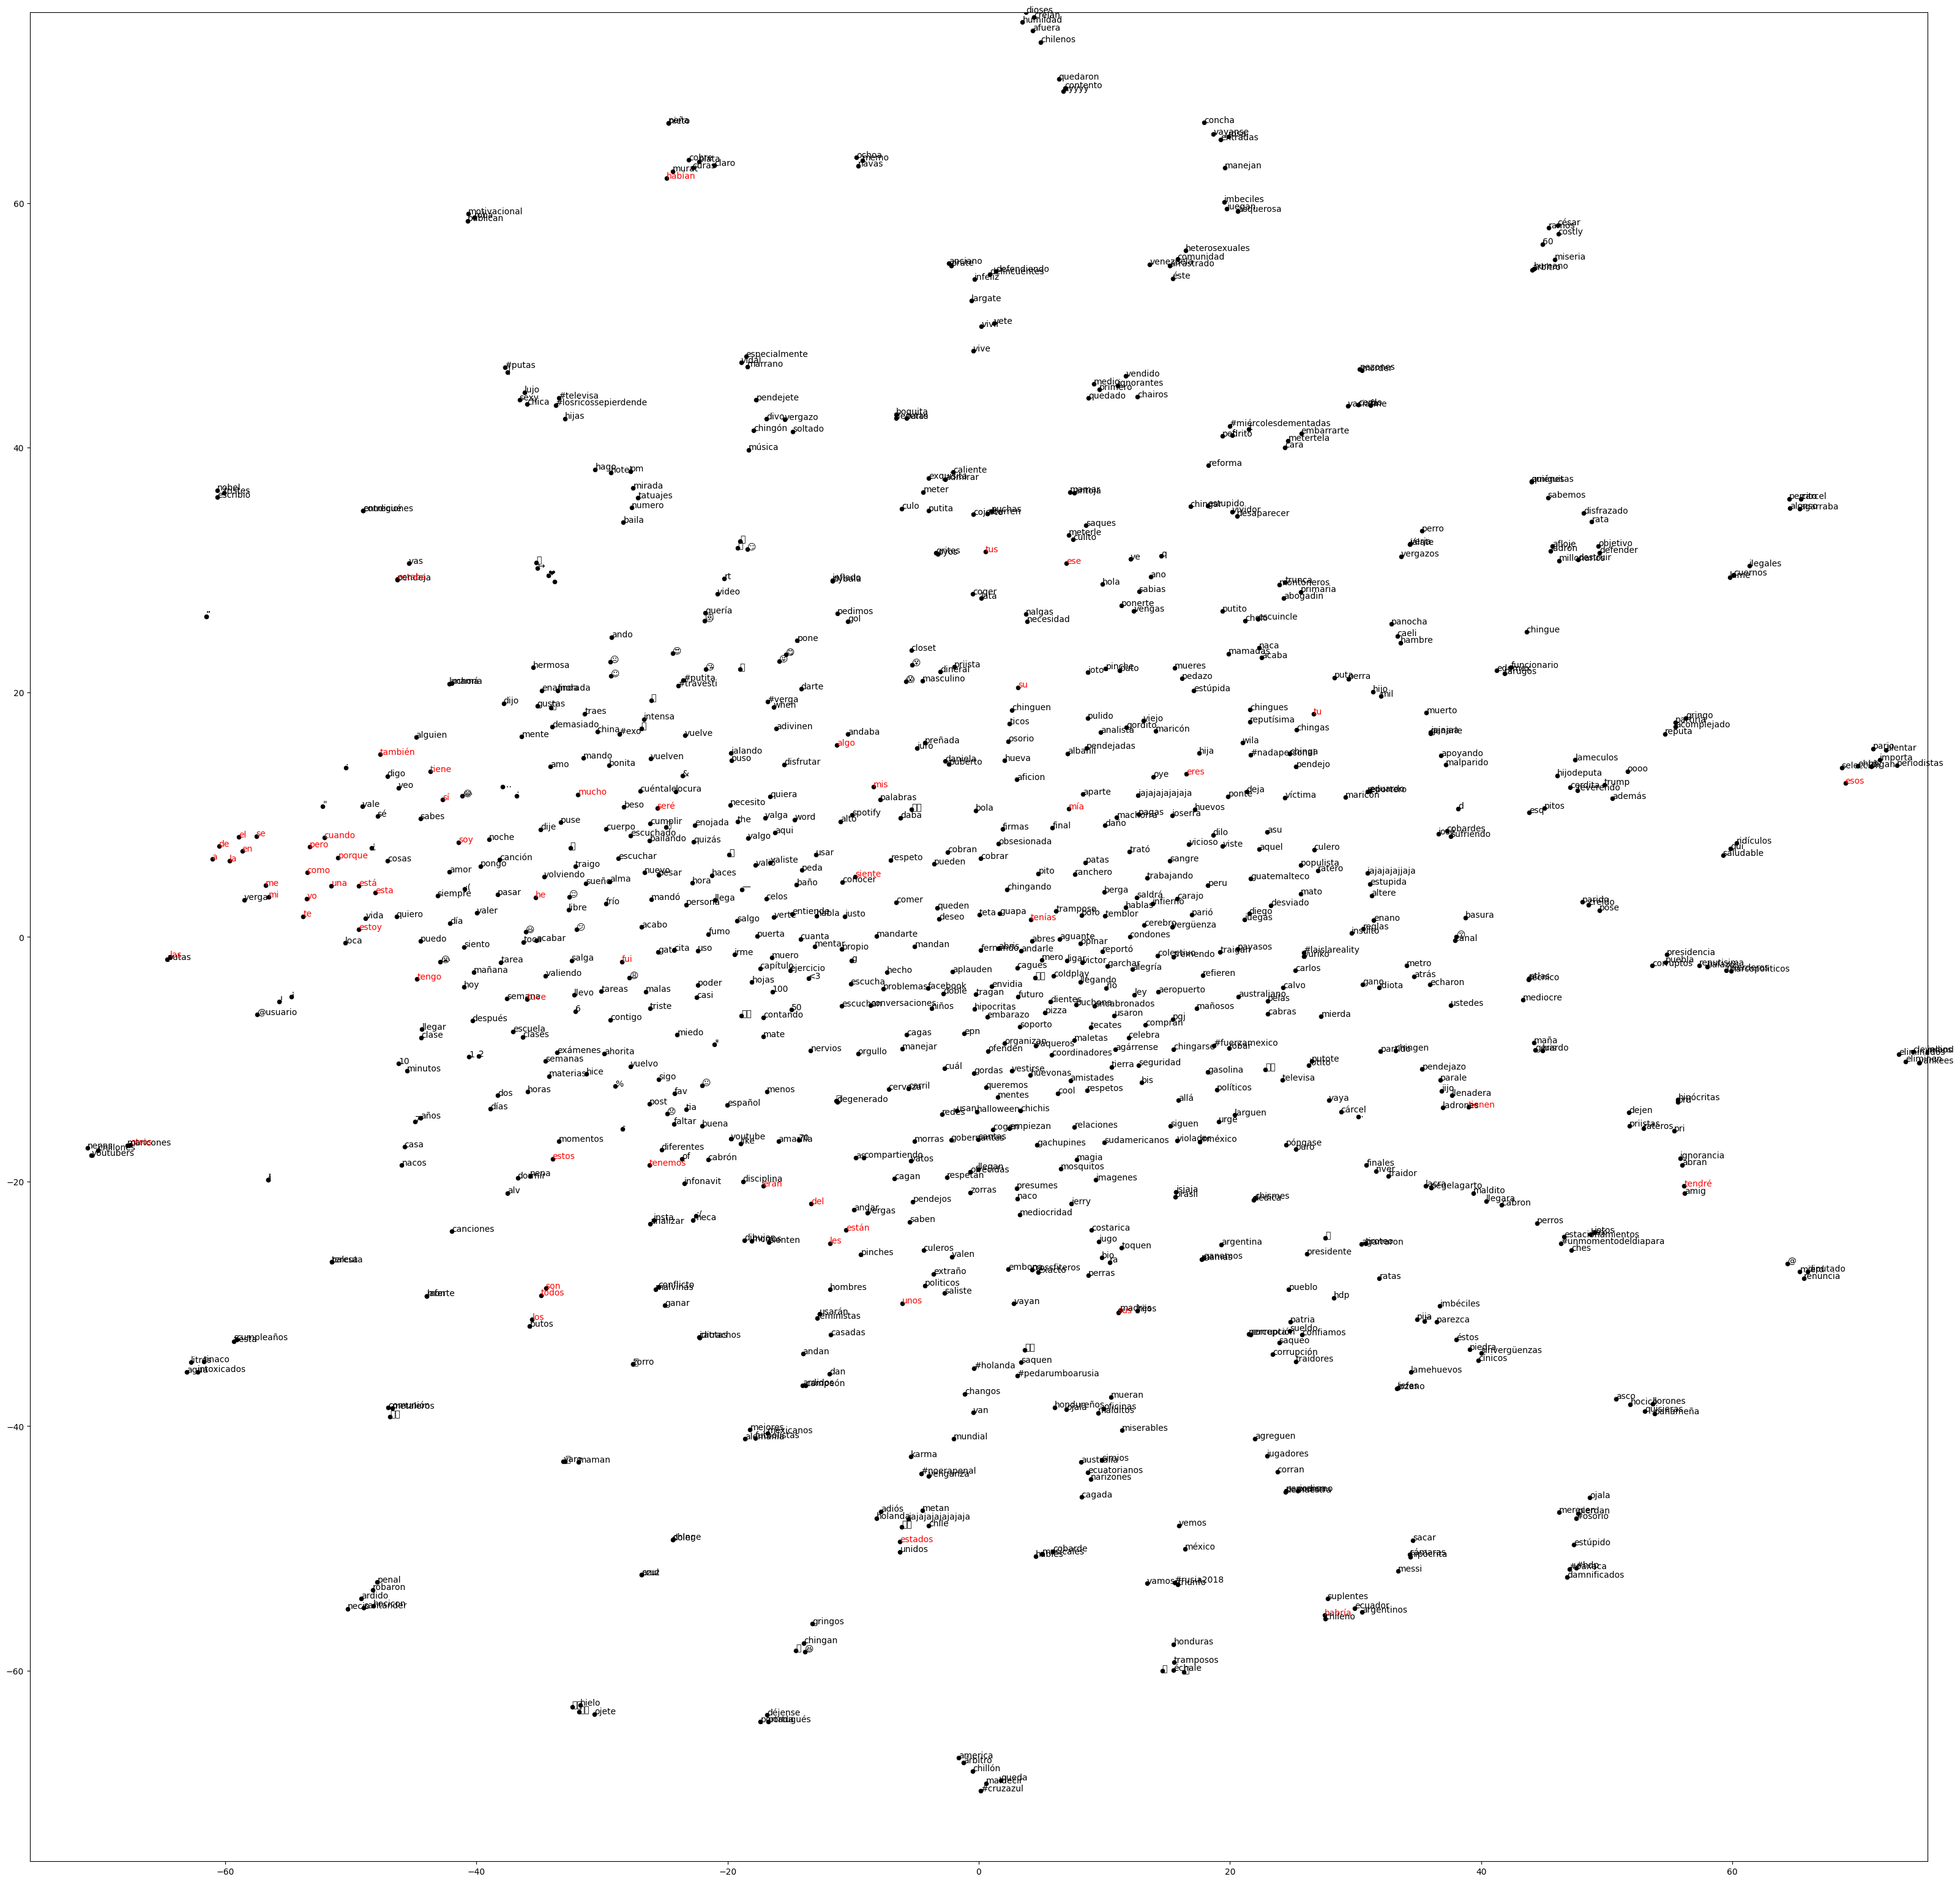

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
sw = set(nltk.corpus.stopwords.words('spanish'))

plt.figure(figsize = (40,40), dpi = 100); plt.xlim((-max_x,max_x)); plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:,0],reduced_matrix[:,1], 20 , color = "black")

for idx, word in enumerate(t_words[:]):
  x = reduced_matrix[idx,0]
  y = reduced_matrix[idx,1]
  if word in sw:
    plt.annotate(word, (x,y),color = "red")
  else:
    plt.annotate(word, (x,y),color = "black")

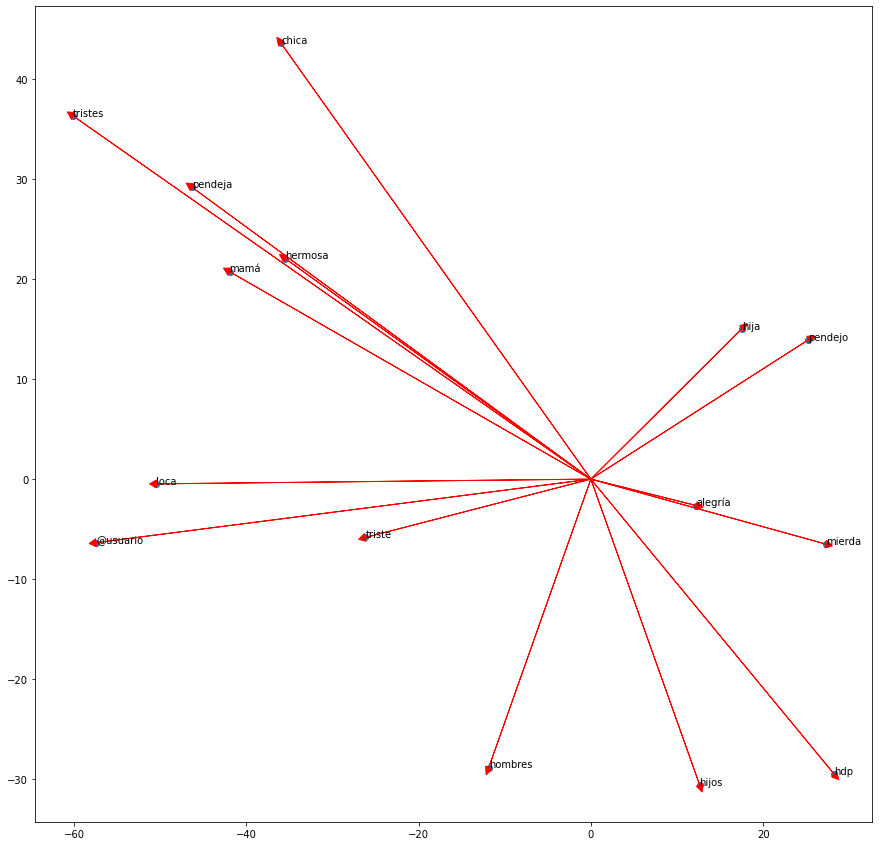

In [ ]:
subsetwords = ["tristes","triste","alegría","hermosa","chica","hombres","hdp","madre","@usuario","hijos","pendeja","pendejo","mierda","loca","hija","mamá","tía"]
ploted_subsewords = []
subreduced_matrix = []

for idx, word in enumerate(t_words[:]):
  if word in subsetwords:
    ploted_subsewords += [word]
    subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize = (15,15))
col1 = 0
col2 = 1

for word in subreduced_matrix:
  ax.arrow(0,0,word[col1],word[col2],head_width = 0.8, head_length = 0.8, fc = 'r', ec = 'r', width = 1e-2)

ax.scatter(subreduced_matrix[:,col1], subreduced_matrix[:,col2])

for i in range(0,len(ploted_subsewords)):
  ax.annotate(ploted_subsewords[i], (subreduced_matrix[i,col1],subreduced_matrix[i,col2]))

plt.show()

## 1. Aplicamos TCOR a la bolsa de palabras construida con el pesado PPMI definido para cada palabra (w) y documento (d):
## PPMI$(w,d) = \max(\log \frac{P(w,d)}{P(x)P(d)})$
## $p_{ij} = \frac{f_{ij}}{\sum_{i=1}^W\sum_{j=1}^D f_{ij}}, ~~~~~~~ p_{i*} = \frac{\sum_{i=1}^D f_{ij}}{\sum_{i=1}^W\sum_{j=1}^D f_{ij}}, ~~~~~~~ p_{*j} = \frac{\sum_{i=1}^W f_{ij}}{\sum_{i=1}^W\sum_{j=1}^D f_{ij}}$

In [153]:
#TCOR (PPMI)
def compute_tcor(TR):
  TR_subset_in = TR #Para seleccionar cierto subset de elementos de la matriz
  DTR = np.zeros((TR_subset_in.shape[1],TR_subset_in.shape[0]),dtype = float)

  print("DOR: Shape of the input matrix (BoT):", TR.shape)
  print("DOR: Shape of the term-term matrix:", DTR.shape)

  #Suma de columnas y filas (para cálculos de probabilidad)
  nt = np.sum(TR_subset_in)
  nwords = np.sum(TR_subset_in,axis = 0)
  ndocs = np.sum(TR_subset_in,axis = 1)


  for doc, i in zip(TR_subset_in, range(len(TR_subset_in))):
    for word, j in zip(TR_subset_in, range(len(TR_subset_in[0]))):   
      DTR[j][i] = max(np.log((TR_subset_in[i,j]/nt)/((ndocs[i]/nt)*(nwords[j]/nt))),0)
    
  return(DTR)

In [154]:
TCOR_base = compute_tcor(BOW_tr)

DOR: Shape of the input matrix (BoT): (5544, 5000)
DOR: Shape of the term-term matrix: (5000, 5544)


<ipython-input-153-2e5d4e2efe96>:17: RuntimeWarning: divide by zero encountered in log
  DTR[j][i] = max(np.log((TR_subset_in[i,j]/nt)/((ndocs[i]/nt)*(nwords[j]/nt))),0)


In [ ]:
from sklearn import preprocessing

TCOR_base = preprocessing.normalize(TCOR_base, norm = 'l2')

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

#Escoger las mejores k features
feats = SelectKBest(chi2, k=1000)
feats.fit(BOW_tr, tr_y)
best = feats.get_support(indices=True)  

In [ ]:
dict_indice_invertido = {}
for w in dict_indices:
  dict_indice_invertido[dict_indices[w]] = w

In [ ]:
t_words = [dict_indice_invertido[index] for index in best]
t_words[:10]

['de', 'a', 'la', 'me', '!', 'el', '@usuario', 'en', 'verga', 'se']

In [ ]:
target_matrix = np.array([TCOR_base[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 5544)

In [ ]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/mex_data/')
from tsne import tsne
#Reducción de dimensiones
reduced_matrix = tsne(target_matrix, 2)

In [ ]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


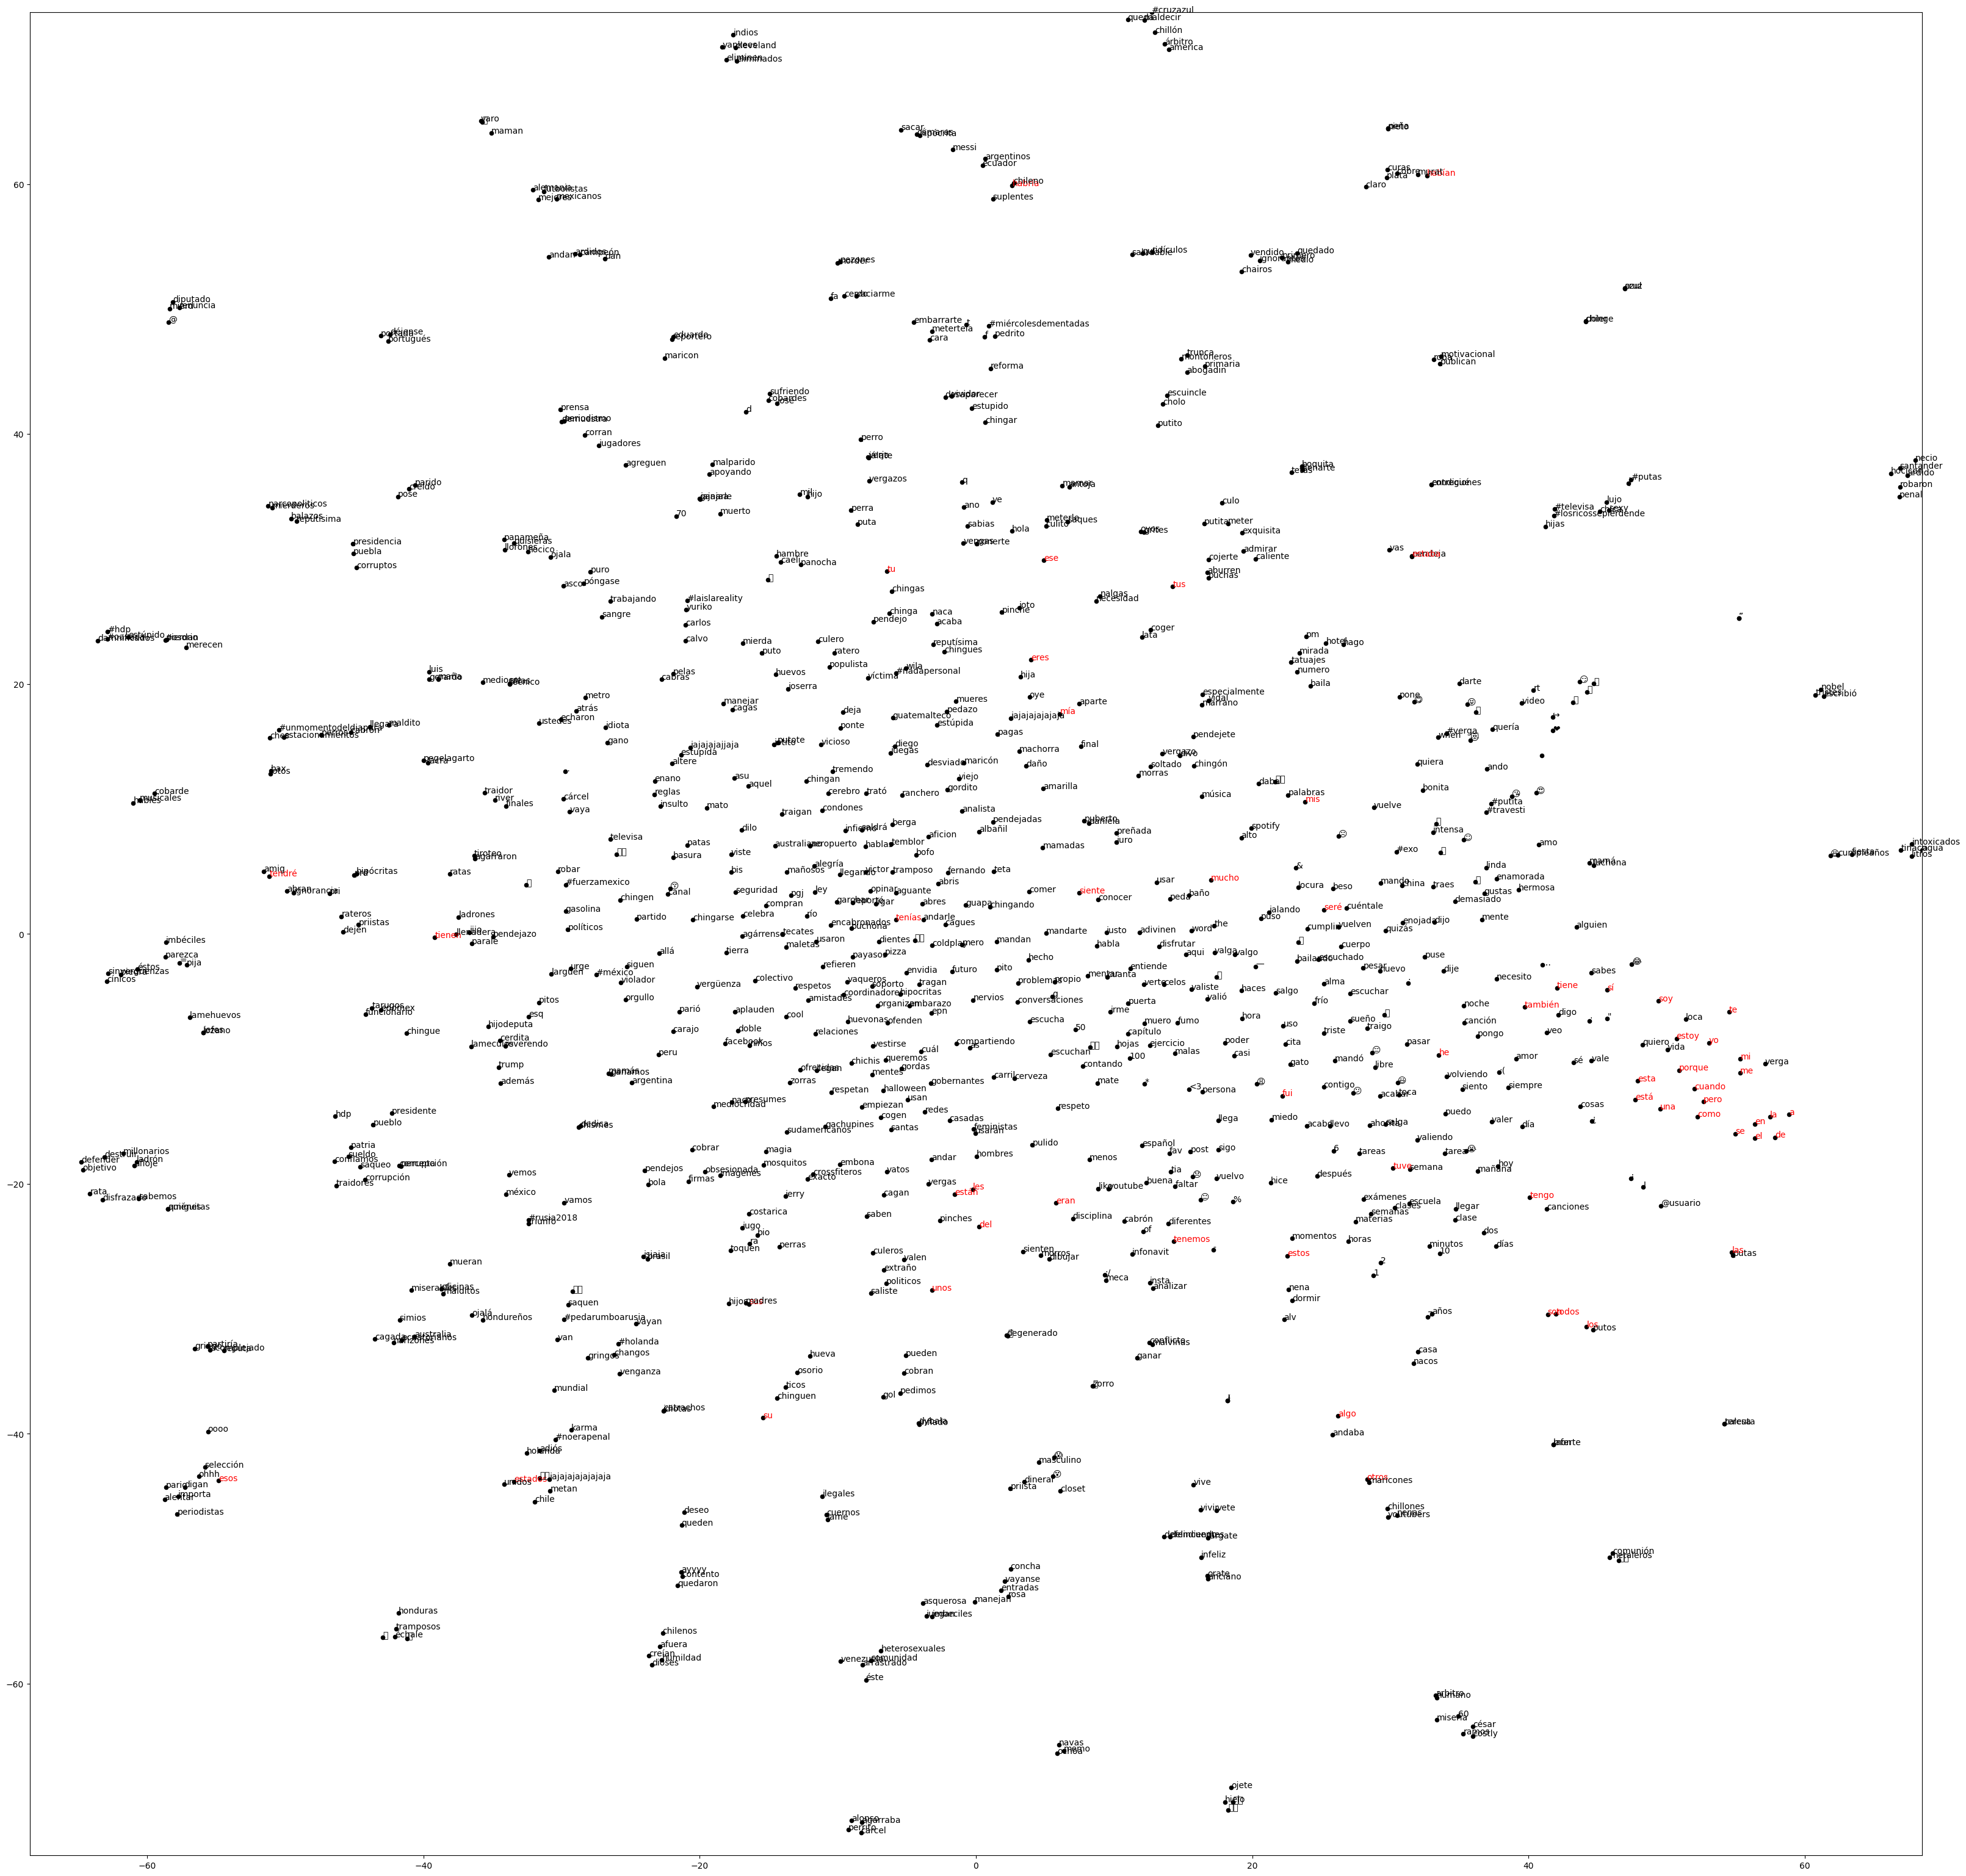

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
sw = set(nltk.corpus.stopwords.words('spanish'))

plt.figure(figsize = (40,40), dpi = 100); plt.xlim((-max_x,max_x)); plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:,0],reduced_matrix[:,1], 20 , color = "black")

for idx, word in enumerate(t_words[:]):
  x = reduced_matrix[idx,0]
  y = reduced_matrix[idx,1]
  if word in sw:
    plt.annotate(word, (x,y),color = "red")
  else:
    plt.annotate(word, (x,y),color = "black")

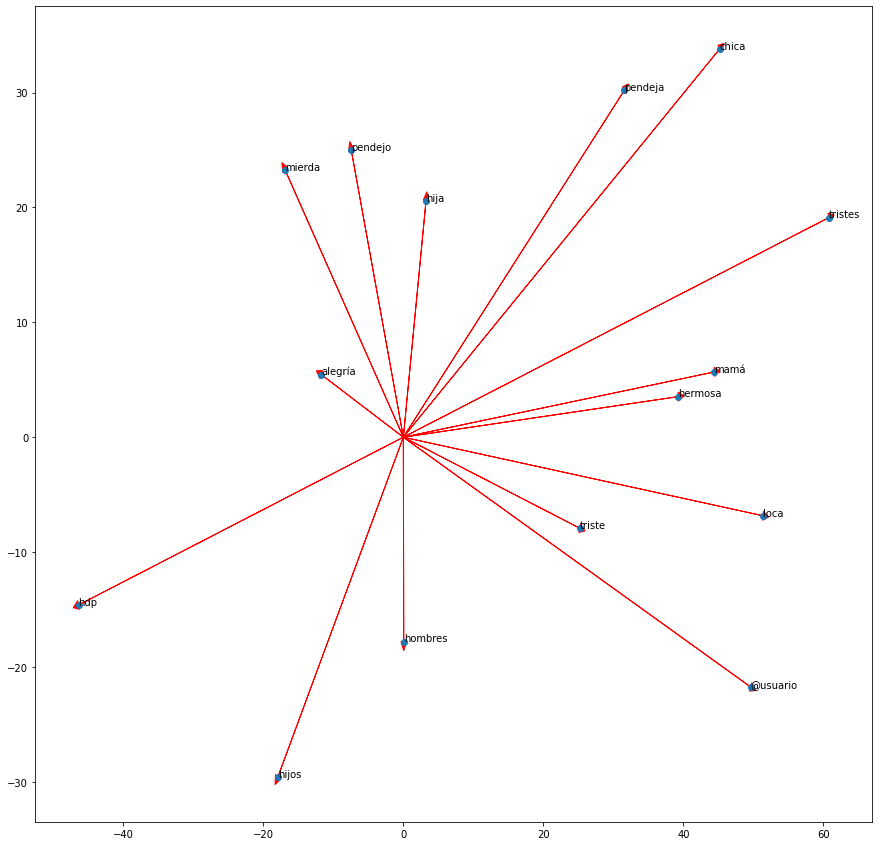

In [ ]:
subsetwords = ["tristes","triste","alegría","hermosa","chica","hombres","hdp","madre","@usuario","hijos","pendeja","pendejo","mierda","loca","hija","mamá","tía"]
ploted_subsewords = []
subreduced_matrix = []

for idx, word in enumerate(t_words[:]):
  if word in subsetwords:
    ploted_subsewords += [word]
    subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize = (15,15))
col1 = 0
col2 = 1

for word in subreduced_matrix:
  ax.arrow(0,0,word[col1],word[col2],head_width = 0.8, head_length = 0.8, fc = 'r', ec = 'r', width = 1e-2)

ax.scatter(subreduced_matrix[:,col1], subreduced_matrix[:,col2])

for i in range(0,len(ploted_subsewords)):
  ax.annotate(ploted_subsewords[i], (subreduced_matrix[i,col1],subreduced_matrix[i,col2]))

plt.show()

## 2. Implementamos Random Indexing tomando una muestra aleatoria de vectores de -1,0,1 para cada documento y sumando los vectores para crear la DTR.

In [105]:
#Random Indexing, k columns
import random as ran
def compute_RI(TR,k):
  TR_subset_in = TR #Para seleccionar cierto subset de elementos de la matriz
  RI = np.zeros((TR_subset_in.shape[0],k),dtype = float)
  DTR = np.zeros((TR_subset_in.shape[1],k),dtype = float)

  print("DOR: Shape of the input matrix (BoT):", TR.shape)
  print("DOR: Shape of the docs-k matrix:", DTR.shape)

  #Random indexing matrix
  for i in range(len(TR_subset_in)):
    for j in range(k):
      r = ran.random()
      if (r > 0.3):
        pass
      else:
        if (r <= 0.15):
          RI[i,j] = -1.0
        else:
          RI[i,j] = 1.0

  for j in range(len(TR_subset_in[0])):
    DTR[j] = np.sum(RI[:][np.nonzero(TR_subset_in[:][j])[0]], axis = 0)
    
  return(DTR)


In [106]:
RI_base = compute_RI(BOW_tr,2000)
RI_base.shape

DOR: Shape of the input matrix (BoT): (5544, 5000)
DOR: Shape of the docs-k matrix: (5000, 2000)


(5000, 2000)

In [107]:
from sklearn import preprocessing
RI_base = preprocessing.normalize(RI_base, norm = 'l2')

In [108]:
from sklearn.feature_selection import SelectKBest, chi2

#Escoger las mejores k features
feats = SelectKBest(chi2, k=1000)
feats.fit(BOW_tr, tr_y)
best = feats.get_support(indices=True)  

In [109]:
dict_indice_invertido = {}
for w in dict_indices:
  dict_indice_invertido[dict_indices[w]] = w

In [110]:
t_words = [dict_indice_invertido[index] for index in best]
t_words[:10]

['de', 'a', 'la', 'me', '!', 'el', '@usuario', 'en', 'verga', 'se']

In [111]:
target_matrix = np.array([RI_base[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 2000)

In [ ]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/Colab Notebooks/mex_data/')
from tsne import tsne
#Reducción de dimensiones
reduced_matrix = tsne(RI_base, 2)

In [117]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-pack

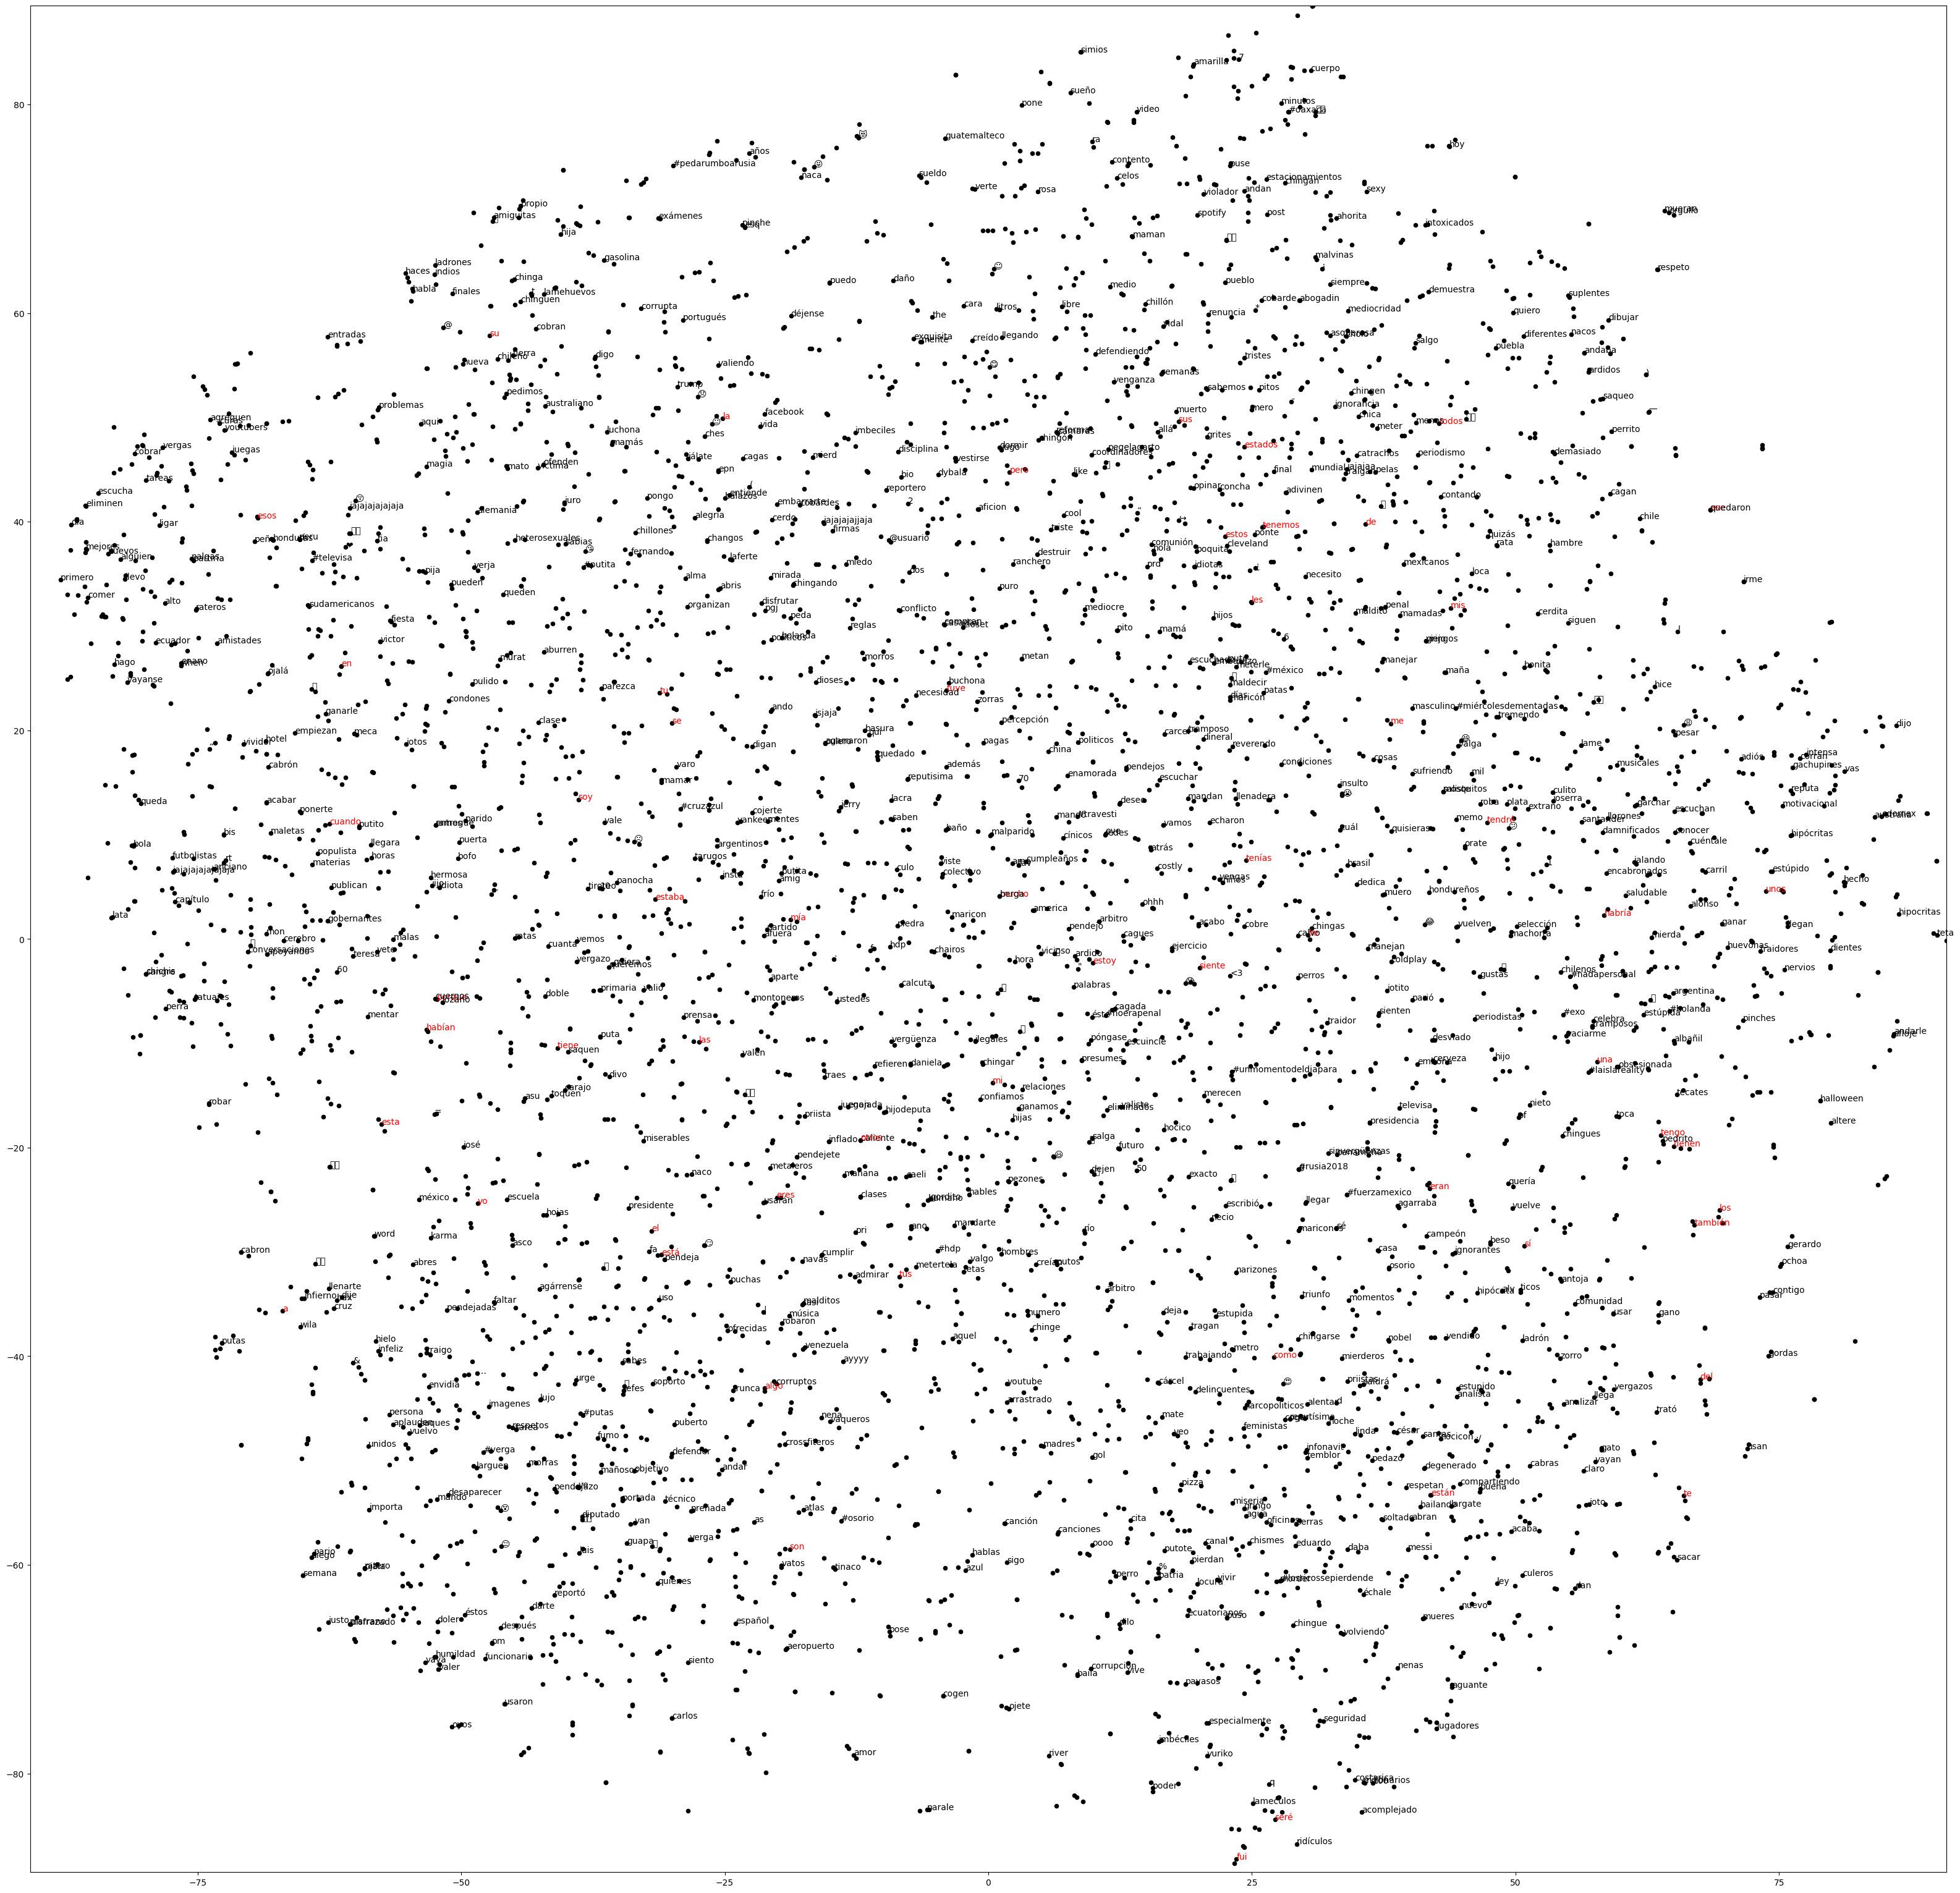

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
sw = set(nltk.corpus.stopwords.words('spanish'))

plt.figure(figsize = (40,40), dpi = 100); plt.xlim((-max_x,max_x)); plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:,0],reduced_matrix[:,1], 20 , color = "black")

for idx, word in enumerate(t_words[:]):
  x = reduced_matrix[idx,0]
  y = reduced_matrix[idx,1]
  if word in sw:
    plt.annotate(word, (x,y),color = "red")
  else:
    plt.annotate(word, (x,y),color = "black")

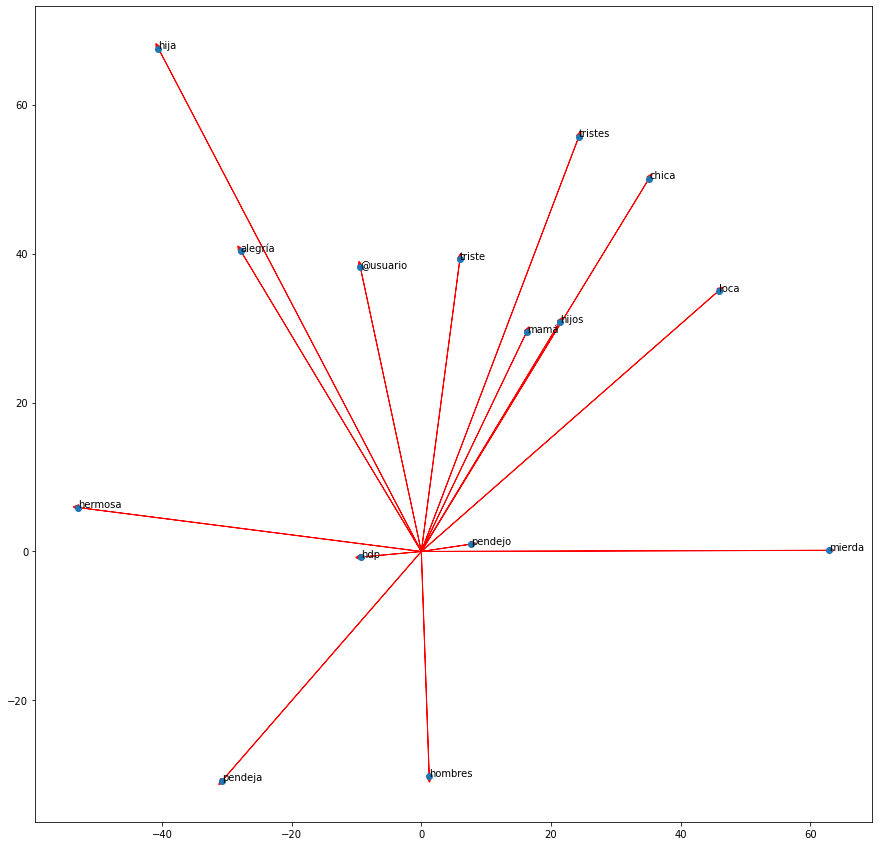

In [119]:
subsetwords = ["tristes","triste","alegría","hermosa","chica","hombres","hdp","madre","@usuario","hijos","pendeja","pendejo","mierda","loca","hija","mamá","tía"]
ploted_subsewords = []
subreduced_matrix = []

for idx, word in enumerate(t_words[:]):
  if word in subsetwords:
    ploted_subsewords += [word]
    subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)

fig, ax = plt.subplots(figsize = (15,15))
col1 = 0
col2 = 1

for word in subreduced_matrix:
  ax.arrow(0,0,word[col1],word[col2],head_width = 0.8, head_length = 0.8, fc = 'r', ec = 'r', width = 1e-2)

ax.scatter(subreduced_matrix[:,col1], subreduced_matrix[:,col2])

for i in range(0,len(ploted_subsewords)):
  ax.annotate(ploted_subsewords[i], (subreduced_matrix[i,col1],subreduced_matrix[i,col2]))

plt.show()

## 3. DOR vs BoW con Tidtf para clasificación

In [178]:
def build_bow_trf(tr_txt,V,dict_indices):
  BOW = np.zeros((len(tr_txt),len(V)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
    
    cont_doc+=1
  
  return BOW

In [179]:
BOW_tr = build_bow_trf(tr_txt, V, dict_indices)
BOW_val = build_bow_trf(val_txt, V, dict_indices)

In [94]:
#Constructor de DOR documento-documento
def dor_doc_const(DOR):
  DOR_doc_tr = np.zeros((DOR.shape[1],DOR.shape[1]),dtype = float)
  for i in range(DOR.shape[1]):
    aux = np.nonzero(DOR[:,i])[0]
    for j in range(DOR.shape[1]):
      DOR_doc_tr[i,j] = sum(DOR[aux,j])
  return(DOR_doc_tr)

DOR_doc_tr = dor_doc_const(DOR_base)
DOR_doc_val = dor_doc_const(DOR_val)

In [95]:
from sklearn import preprocessing
DOR_doc_tr = preprocessing.normalize(DOR_doc_tr, norm = 'l2')
DOR_doc_val = preprocessing.normalize(DOR_doc_val, norm = 'l2')

In [96]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score

In [56]:
val_y = list(map(int, val_y))
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[334  63]
 [ 49 170]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       397
           1       0.73      0.78      0.75       219

    accuracy                           0.82       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.82      0.82       616



In [97]:
val_y = list(map(int, val_y))
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(DOR_doc_tr, tr_y)
y_pred = grid.predict(DOR_doc_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

ValueError: ignored

## 4. L Pares de palabras con mayor similitud con la distancia del coseno
## Cosine $(U,V) = \frac{U \cdot V}{|U||V|}$

Mostramos a continuación las 30 palabras con mayor similitud según la distancia del coseno. Se observa que la mayoría son concordancias de palabras que normalmente no se usan por separado.

In [160]:
from sklearn import preprocessing

TCOR_basen = preprocessing.normalize(TCOR_base, norm = 'l2')

In [181]:
def cosineW(u,v):
  return(np.dot(u,v))

def bestkcosine(TCOR):
  #TCOR = TCOR[:3000]
  best = {}
  for i in range(len(TCOR)):
    for j in range(i+1,len(TCOR)):
      temp = cosineW(TCOR[i],TCOR[j])
      if temp != 0:
        best[(i,j)] = temp

  best = dict(sorted(best.items(), key=lambda x:x[1], reverse=True))
  return(best)

Tfidf_bow = bestkcosine(Tfidf_bow)

In [177]:
hk = list(bestk.keys())[:30]
for i in range(len(hk)):
  print(V[hk[i][0]][1],V[hk[i][1]][1])


🇽 🇲
sugar daddy
tetona dotación
pege dna
leather cookies
kim kardashian
hirviendo grados
] [
#tiernita #fer
zamoranos chongos
づ ◕
xxi siglo
santurrona probó
ramos césar
ramos costly
mon laferte
laburo contratos
laburo conducta
laburo cdo
entregué condiciones
ensarte cabalga
destiempo alguno
césar costly
contratos conducta
contratos cdo
conducta cdo
#ruggeropasquarelli #kcacolombia
#ruggeropasquarelli #karolsevilla
#reggaetonlento #heydj
#kcacolombia #karolsevilla


## 5. Encontramos de la misma forma los documentos más similares con bajo una BoW TFIDF.
Los 30 documentos más similares por distancia del coseno se imprimen a continuación separados por pares.

In [180]:
from sklearn import preprocessing

Tfidf_bow = preprocessing.normalize(BOW_tr, norm = 'l2')


In [193]:
hk = list(bestk.keys())[:30]
for i in range(len(hk)):
  print(tr_txt[hk[i][0]],tr_txt[hk[i][1]],"\n")

les gustan los mexxxicanos delgados? que el este que nos comparte su verga?
 mi mamá regalo dos jeans que uso que putas madres le pasa por la cabeza 😩😩😩😩
 

@usuario @usuario  no mames si estamos peor de verdad no tienes madre pinche hipócrita sínico ratero de mierda
 no te quiero en mi selección hijo de tu puta madre cómo mandas a un defensa cuando tienes toda la ventaja y puedes hasta meter más goles
 

no mamen como si con 3000 putos pesos dejarán a resolver la situación
 ese miñero hasta que usas zapatos saludos puñal buen programa😎
 

si lees bien el tuit estaba tragando cereal y no verga ☝️
 confieso que últimamente me vale verga todo.😔 #nochedeconfesiones
 

mis vecinos escuchando las canciones viejitas de gloria trevi quien putas los violó de chiquitos?!
 hermano déjate caer algo de @usuario los tienes más cepillados que al joto de la chofis
 

pinche maricón arrastrado y ridículo. pinches putos por eso nadie los acepta. pendejos relegados de mierda.
 por qué verga creen que el